# Predictive Analysis on Clinical Trial Outcomes

#### Investigator
- [Nicholas S. McBride, PhD](https://www.linkedin.com/in/nsmcbride/)

## Section 3: Exploratory Data Analysis

##### [ClinicalTrials.gov](https://clinicaltrials.gov/) Reference Links

- [API documentation](https://clinicaltrials.gov/data-api/api)
- [Data structure](https://clinicaltrials.gov/data-api/about-api/study-data-structure)
- [ESSIE query syntax](https://clinicaltrials.gov/find-studies/constructing-complex-search-queries)

In [1]:
# Imports
import numpy as np
import pandas as pd
import bz2
import pickle
from time import time

import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

In [2]:
# Google Colab environment
# Determine if runtime is a Google Colab enviroment
colab = 'google.colab' in str(get_ipython())

# Workspace settings
if colab:
    project_path = data_path = './'
else:
    project_path = '../'
    data_path = project_path + 'data/'

# Visualization settings
%config InlineBackend.figure_formats = ['retina'] # High res PNGs
plt.style.use('ggplot')

In [3]:
# Load list of in scope fields
with open(project_path + 'inscope_fields.txt') as file:
    fields = file.read().splitlines()
print(f'Fields selected: {len(fields)}')

# Load API field information from pickle
field_info = pd.read_pickle(data_path + 'field_info.pkl.bz2')

# Create dicts to lookup field name from piece name and the reverse
field_to_piece = dict(field_info[['field', 'piece']].values)
piece_to_field = dict(field_info[['piece', 'field']].values)
piece_to_type = dict(field_info[['piece', 'type']].values)

pieces = [field_to_piece[field] for field in fields]

# Create dicts to lookup field name from piece name and the  reverse
field_to_piece = dict(field_info[['field', 'piece']].values)
piece_to_field = dict(field_info[['piece', 'field']].values)

Fields selected: 115


In [4]:
# Read DataFrame from pickle
start_time = time()

studies_df_filename = 'studies_df.pkl.bz2'
studies = pd.read_pickle(data_path + studies_df_filename)

print(f'Data loaded in {round(time() - start_time, 1)}s')

Data loaded in 15.1s


### Set Index to NCTId
NCTId represents the study ID.

In [5]:
studies.set_index('NCTId', inplace=True)

### Target Variable
To begin exploratory analysis, we examine the target classes.

In [6]:
studies['OverallStatus'].value_counts()

OverallStatus
COMPLETED                    270479
UNKNOWN                       67141
TERMINATED                    28794
WITHDRAWN                     14144
SUSPENDED                      1638
NO_LONGER_AVAILABLE             452
AVAILABLE                       263
APPROVED_FOR_MARKETING          199
TEMPORARILY_NOT_AVAILABLE        25
Name: count, dtype: int64

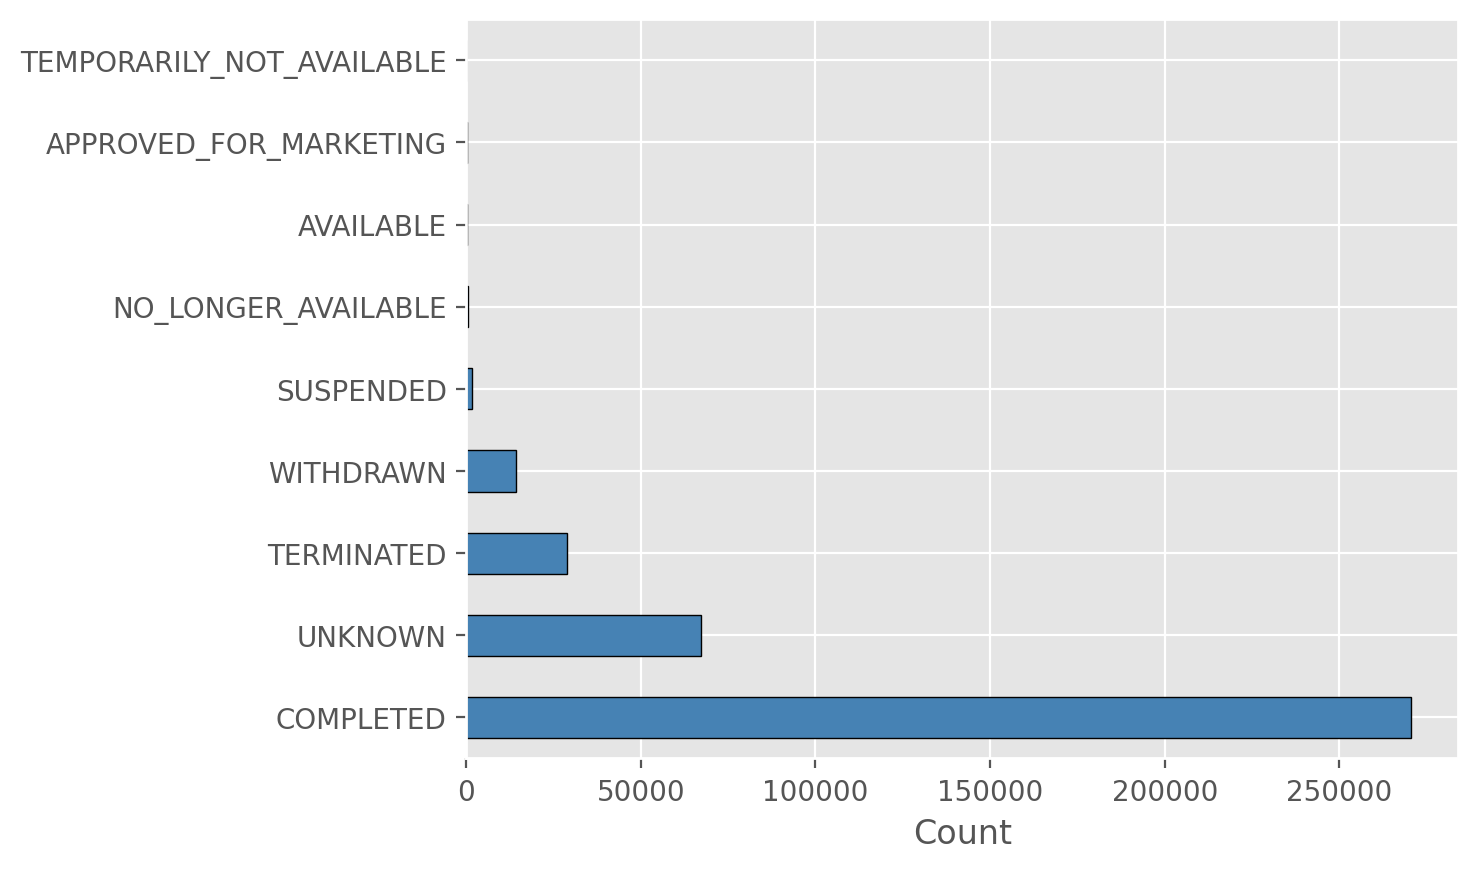

In [7]:
studies['OverallStatus'].value_counts().plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('Count')
plt.ylabel(None)
plt.show();

Let's take a closer look at the Expanded Access studies by separating them out.

In [8]:
recruitment = ['COMPLETED', 'SUSPENDED', 'TERMINATED' , 'WITHDRAWN', 'UNKNOWN']
expanded_access = ['AVAILABLE', 'NO_LONGER_AVAILABLE', 'TEMPORARILY_NOT_AVAILABLE', 'APPROVED_FOR_MARKETING']

print('Proportion of studies with an Expanded Access status')
print(studies.loc[studies["OverallStatus"].isin(expanded_access)].count().sum() / studies.shape[0])

Proportion of studies with an Expanded Access status
0.05804742453704308


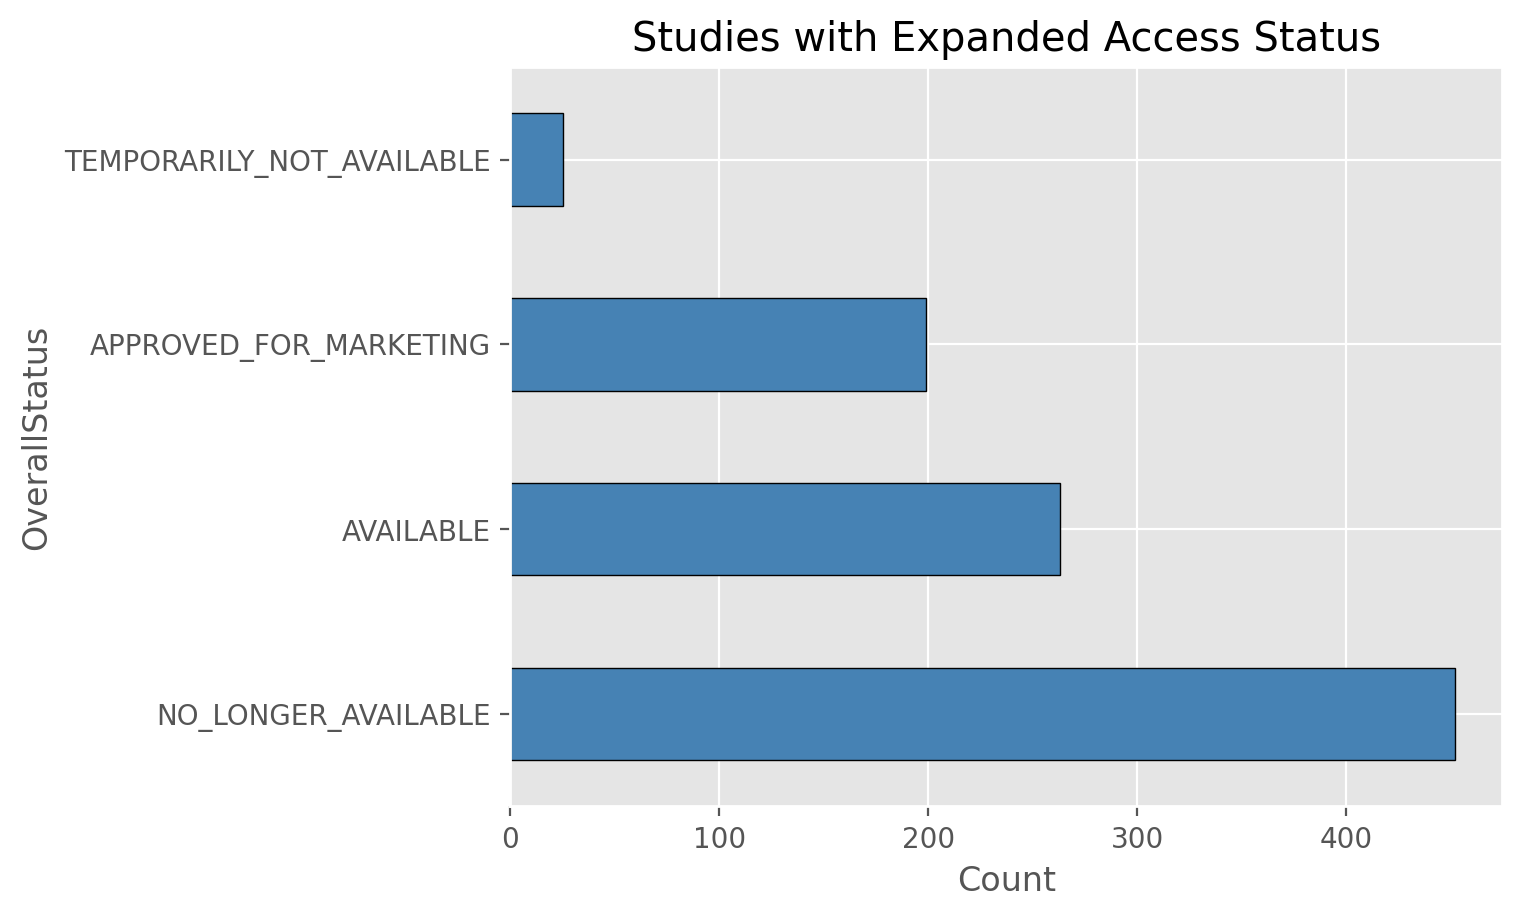

In [9]:
studies.loc[studies['OverallStatus'].isin(expanded_access), 
            'OverallStatus'].cat.remove_unused_categories().value_counts().plot(kind='barh', 
                                                 color='steelblue', 
                                                 edgecolor='black')
plt.title('Studies with Expanded Access Status')
plt.xlabel('Count')
plt.show();

[Information on Expanded Access is available here](https://www.fda.gov/news-events/public-health-focus/expanded-access) and [ClinicalTrials.gov definitions for Expanded Access records are available here](https://www.clinicaltrials.gov/policy/expanded-access-definitions). According to these definitions, Expanded Access records are not clinical trial records. Given this information and how unbalanced the inclusion of Expanded Access records would make the dataset, it may be worth excluding these records if they prove difficult to classify.

In this regard, the most complex analysis we will endeavor will be a multiple classification of all `OverallStatus` values in the dataset, while a simplified analysis would entail a binary classification of Completed vs. Incomplete (Terminated, Suspended, Withdrawn, or Unknown) recruitment status studies only.

### Determine Variable Inclusion and Encoding Parameters

Columns that contain free-text for many, many values approaching a fraction of the number of observations will not be suitable as predictive features. While NLP analysis of free text could be a powerful approach here, it is outside of the scope of this analysis and could be grounds for future research given additional resources.

In [10]:
# Functions for evaluating dependent variables and unpacking and encoding nested lists

def find_list_columns(df):
    """
    Iterates over the columns of a pd.DataFrame to determine is any of the values are a list type.
    Returns a list of the names of columns that contain lists.
    """
    return list(df.columns[df.map(lambda value: isinstance(value, list)).any()])

def flatten(nested_list):
    """
    Flattens and arbitraily nested list using recursion.
    """

    # Catch Nonetypes
    if nested_list is None:
        return None
    
    flat_list = []
    for item in nested_list:
        if isinstance(item, list):
            flat_list.extend(flatten(item))
        else:
            flat_list.append(item)
    return flat_list

def summarize_values(series, top_n=None, normalize=False):
    """
    Sums value across a pd.Series to create a summary of value counts.
    """
    result = series.value_counts(dropna=False, normalize=normalize)
    if top_n:
        other = sum(result) - sum(result.nlargest(top_n))
        return pd.concat([result.nlargest(top_n), pd.Series(other, index=['Other'])])
    else:
        return result

def summarize_list_values(series, top_n=None, normalize=False):
    """
    Applies the flatten helper function across a series and sums them to create a summary of value counts.
    """
    result = pd.Series(flatten([row for row in series])).value_counts(dropna=False, normalize=normalize)
    if top_n:
        other = sum(result) - sum(result.nlargest(top_n))
        return pd.concat([result.nlargest(top_n), pd.Series(other, index=['Other'])])
    else:
        return result

def make_list_lowercase(string_list):
    # print(type(string_list))
    if isinstance(string_list, list):
        return [string.strip().lower() if isinstance(string, str) else string for string in string_list]
    else:
        return string_list

def unpack_list_individual(nested_list, make_lowercase=False):
    """
    Helped function to unpack nested lists and encode them as a dictionary with counts.
    """

    # Catch and return NoneTypes
    if nested_list is None:
        return None
    
    flat_list = flatten(nested_list)
    if make_lowercase:
        flat_list = make_list_lowercase(flat_list)
    
    return {item: flat_list.count(item) for item in set(flat_list)}

def unpack_list(series, make_lowercase=False, max_categories=None, other_string='ALL_OTHERS', none_string='No_data'):
    """
    Applies the unpack_list helper function across a series to produce a pd.DataFrame with one column per unique value.
    Applies the helper function unpack_list_individual() directly when called on an individual list.
    """
    
    if isinstance(series, list):
        return unpack_list_individual(series)

    # Flatten the series
    series = series.map(flatten)

    # Make lowercase
    if make_lowercase:
        series = series.map(make_list_lowercase)
    
    # Get top categories
    if max_categories:
        all_categories = pd.Series(flatten([row for row in series])).value_counts(dropna=False)
        if max_categories == all_categories.shape[0]:
            top_categories = list(all_categories.nlargest(max_categories).index)
        else:
            top_categories = list(all_categories.nlargest(max_categories - 1).index)
        
        # Replace None with none_string in top_categories
        top_categories = [none_string if category is None else category for category in top_categories]
    
    # Unpack all the lists
    series = series.map(lambda x: unpack_list_individual(x, make_lowercase=make_lowercase))
    
    # Initialize an empty pd.DataFrame with the same index as series
    df = pd.DataFrame(index=series.index)

    # Initialize a column to count the number of values in each row
    df['num_' + series.name] = np.int32()

    for i in series.index:
        unpacked = series[i]

        # Catch NoneTypes
        if unpacked is None:
            unpacked = {none_string: 1}

        # Sum to total number of values
        df.at[i, 'num_' + series.name] = sum(unpacked.values())
        
        for key, value in unpacked.items():

            # Set value not in the top categories to the `other_string`
            if max_categories and key not in top_categories:
                key = other_string
            
            new_col_name = series.name + '_' + str(key)
            if new_col_name in df.columns:
                df.at[i, new_col_name] += value
            else:
                df[new_col_name] = np.int32()
                df.at[i, new_col_name] = value
    
    return df

In [11]:
# Determine which columns contain embedded lists to be unpacked
list_cols = find_list_columns(studies)

The columns in the current dataset are still missing several of those that were selected.

In [12]:
missing_pieces = [piece for piece in pieces if piece not in studies.columns and piece != 'NCTId']
print(len(missing_pieces))
missing_pieces

29


['NumLargeDocs',
 'NumArmGroupInterventionNames',
 'NumInterventionArmGroupLabels',
 'NumInterventionOtherNames',
 'NumArmGroups',
 'NumInterventions',
 'NumConditions',
 'NumKeywords',
 'NumLocationContacts',
 'NumCentralContacts',
 'NumLocations',
 'NumOverallOfficials',
 'NumUniqueLocationCountries',
 'NumDesignWhoMaskeds',
 'NumPhases',
 'NumStdAges',
 'NumSecondaryIds',
 'NumIPDSharingInfoTypes',
 'NumOtherOutcomes',
 'NumOutcomes',
 'NumPrimaryOutcomes',
 'NumSecondaryOutcomes',
 'NumAvailIPDs',
 'NumReferences',
 'NumRetractionsAllRefs',
 'NumSeeAlsoLinks',
 'NumRetractionsForRef',
 'NumCollaborators',
 'DelayedPosting']

Further review of API documentation reveals that the numerical count fields are "available for search but not for retrieval". `DelayedPosting` does not indicate this, however the documentation suggests it is a metadata field that may only be present before a study is posted publicly, stating only "It's a system generated status". Since they are not available, these fields can either be excluded from the analysis or recalculated from obtainable data.

#### Single-Value Fields
Here we will determine which categorical independent variables to include, and which is any to subset the top values for inclusion. The documented data types for each column are show below.

In [13]:
for col in studies.columns:
    print(f'{piece_to_type[col]}\t{col}')

STRING	OrgFullName
ENUM	OrgClass
DATE	StatusVerifiedDate
ENUM	OverallStatus
BOOLEAN	HasExpandedAccess
DATE	StartDate
DATE	PrimaryCompletionDate
ENUM	PrimaryCompletionDateType
DATE	CompletionDate
ENUM	CompletionDateType
DATE	StudyFirstSubmitDate
DATE	StudyFirstSubmitQCDate
DATE	LastUpdateSubmitDate
ENUM	ResponsiblePartyType
STRING	LeadSponsorName
ENUM	LeadSponsorClass
BOOLEAN	OversightHasDMC
ENUM	StudyType
ENUM	DesignAllocation
ENUM	DesignInterventionModel
ENUM	DesignPrimaryPurpose
ENUM	DesignMasking
INTEGER	EnrollmentCount
ENUM	EnrollmentType
BOOLEAN	HealthyVolunteers
ENUM	Sex
NUMBER	MinimumAge
NUMBER	MaximumAge
STRING	ResponsiblePartyInvestigatorTitle
STRING	ResponsiblePartyInvestigatorAffiliation
ENUM	StartDateType
BOOLEAN	IsFDARegulatedDrug
BOOLEAN	IsFDARegulatedDevice
ENUM	IPDSharing
DATE	DispFirstSubmitDate
DATE	DispFirstSubmitQCDate
STRING	WhyStopped
BOOLEAN	PatientRegistry
NUMBER	TargetDuration
ENUM	DesignObservationalModel
ENUM	DesignTimePerspective
ENUM	SamplingMethod
ENUM	Bio

In [14]:
cat_pieces = [piece for piece in pieces if piece in studies.columns and piece_to_type[piece] in ['BOOLEAN', 'ENUM', 'STRING']]

cat_pieces_single = [piece for piece in cat_pieces if piece not in list_cols]
cat_pieces_list = [piece for piece in cat_pieces if piece in list_cols]
print(len(cat_pieces_single))
cat_pieces_single

41


['LargeDocNoSAP',
 'BioSpecRetention',
 'DesignAllocation',
 'DesignInterventionModel',
 'DesignMasking',
 'DesignObservationalModel',
 'DesignPrimaryPurpose',
 'DesignTimePerspective',
 'EnrollmentType',
 'ExpAccTypeIndividual',
 'ExpAccTypeIntermediate',
 'ExpAccTypeTreatment',
 'PatientRegistry',
 'StudyType',
 'GenderBased',
 'HealthyVolunteers',
 'SamplingMethod',
 'Sex',
 'OrgClass',
 'OrgFullName',
 'OrgStudyIdType',
 'IPDSharing',
 'FDAAA801Violation',
 'IsFDARegulatedDevice',
 'IsFDARegulatedDrug',
 'IsPPSD',
 'IsUnapprovedDevice',
 'IsUSExport',
 'OversightHasDMC',
 'LeadSponsorClass',
 'LeadSponsorName',
 'ResponsiblePartyInvestigatorAffiliation',
 'ResponsiblePartyInvestigatorTitle',
 'ResponsiblePartyType',
 'CompletionDateType',
 'HasExpandedAccess',
 'ExpandedAccessStatusForNCTId',
 'OverallStatus',
 'PrimaryCompletionDateType',
 'StartDateType',
 'WhyStopped']

##### Transform Strings to  Lowercase

This will remove differences in capitalization leading to term fragmentation. Whitespace will also be stripped.

In [15]:
for col in [piece for piece in cat_pieces_single if piece_to_type[piece] == 'STRING']:
    print(f'Transforming {col} to lowercase and stripping whitespace')
    studies[col] = studies[col].str.strip().str.lower()

Transforming OrgFullName to lowercase and stripping whitespace
Transforming LeadSponsorName to lowercase and stripping whitespace
Transforming ResponsiblePartyInvestigatorAffiliation to lowercase and stripping whitespace
Transforming ResponsiblePartyInvestigatorTitle to lowercase and stripping whitespace
Transforming WhyStopped to lowercase and stripping whitespace


##### Review of Fields

In [16]:
for col in cat_pieces_single:
    print(col)
    print(f'Documented data type: {field_info.loc[field_info["piece"] == col, "type"].item()}\n')
    display(summarize_values(studies[col], 100, normalize=True))
    print('\n------------------\n')

LargeDocNoSAP
Documented data type: BOOLEAN



NaN      0.998716
True     0.001284
Other    0.000000
dtype: float64


------------------

BioSpecRetention
Documented data type: ENUM



NaN                    0.958010
SAMPLES_WITH_DNA       0.024007
SAMPLES_WITHOUT_DNA    0.016475
NONE_RETAINED          0.001509
Other                  0.000000
dtype: float64


------------------

DesignAllocation
Documented data type: ENUM



RANDOMIZED        0.516390
NaN               0.237219
NA                0.162530
NON_RANDOMIZED    0.083861
Other             0.000000
dtype: float64


------------------

DesignInterventionModel
Documented data type: ENUM



PARALLEL        0.453822
NaN             0.239534
SINGLE_GROUP    0.210960
CROSSOVER       0.070450
SEQUENTIAL      0.013922
FACTORIAL       0.011312
Other           0.000000
dtype: float64


------------------

DesignMasking
Documented data type: ENUM



NONE         0.415746
NaN          0.236034
DOUBLE       0.111679
SINGLE       0.110241
QUADRUPLE    0.073371
TRIPLE       0.052929
Other        0.000000
dtype: float64


------------------

DesignObservationalModel
Documented data type: ENUM



NaN                      0.795291
COHORT                   0.116210
CASE_CONTROL             0.031485
CASE_ONLY                0.030814
OTHER                    0.018129
ECOLOGIC_OR_COMMUNITY    0.002921
CASE_CROSSOVER           0.002239
DEFINED_POPULATION       0.001699
FAMILY_BASED             0.000981
NATURAL_HISTORY          0.000230
Other                    0.000000
dtype: float64


------------------

DesignPrimaryPurpose
Documented data type: ENUM



TREATMENT                   0.496183
NaN                         0.240868
PREVENTION                  0.085189
OTHER                       0.038991
SUPPORTIVE_CARE             0.038738
BASIC_SCIENCE               0.038449
DIAGNOSTIC                  0.033672
HEALTH_SERVICES_RESEARCH    0.018704
SCREENING                   0.006452
DEVICE_FEASIBILITY          0.002279
ECT                         0.000475
Other                       0.000000
dtype: float64


------------------

DesignTimePerspective
Documented data type: ENUM



NaN                0.787728
PROSPECTIVE        0.140311
RETROSPECTIVE      0.036515
CROSS_SECTIONAL    0.027533
OTHER              0.007914
Other              0.000000
dtype: float64


------------------

EnrollmentType
Documented data type: ENUM



ACTUAL       0.769658
ESTIMATED    0.188370
NaN          0.041972
Other        0.000000
dtype: float64


------------------

ExpAccTypeIndividual
Documented data type: BOOLEAN



NaN      0.999337
True     0.000663
Other    0.000000
dtype: float64


------------------

ExpAccTypeIntermediate
Documented data type: BOOLEAN



NaN      0.999538
True     0.000462
Other    0.000000
dtype: float64


------------------

ExpAccTypeTreatment
Documented data type: BOOLEAN



NaN      0.999525
True     0.000475
Other    0.000000
dtype: float64


------------------

PatientRegistry
Documented data type: BOOLEAN



NaN      0.841189
False    0.140287
True     0.018523
Other    0.000000
dtype: float64


------------------

StudyType
Documented data type: ENUM



INTERVENTIONAL     0.777687
OBSERVATIONAL      0.219862
EXPANDED_ACCESS    0.002451
Other              0.000000
dtype: float64


------------------

GenderBased
Documented data type: BOOLEAN



NaN      0.97724
True     0.02276
Other    0.00000
dtype: float64


------------------

HealthyVolunteers
Documented data type: BOOLEAN



False    0.702144
True     0.275976
NaN      0.021880
Other    0.000000
dtype: float64


------------------

SamplingMethod
Documented data type: ENUM



NaN                       0.790873
NON_PROBABILITY_SAMPLE    0.149062
PROBABILITY_SAMPLE        0.060065
Other                     0.000000
dtype: float64


------------------

Sex
Documented data type: ENUM



ALL       0.854733
FEMALE    0.098193
MALE      0.045963
NaN       0.001112
Other     0.000000
dtype: float64


------------------

OrgClass
Documented data type: ENUM



OTHER        0.672619
INDUSTRY     0.251186
NIH          0.028752
OTHER_GOV    0.025678
FED          0.009908
NETWORK      0.009012
UNKNOWN      0.001522
INDIV        0.001323
Other        0.000000
dtype: float64


------------------

OrgFullName
Documented data type: STRING



national institutes of health clinical center (cc)    0.010158
glaxosmithkline                                       0.008960
pfizer                                                0.008376
national cancer institute (nci)                       0.007843
novartis                                              0.007700
                                                        ...   
medical university of south carolina                  0.001488
eisai inc.                                            0.001483
university hospital, grenoble                         0.001480
university of oxford                                  0.001475
Other                                                 0.697475
Length: 101, dtype: float64


------------------

OrgStudyIdType
Documented data type: ENUM



NaN      0.989602
NIH      0.010062
AHRQ     0.000313
FDA      0.000023
Other    0.000000
dtype: float64


------------------

IPDSharing
Documented data type: ENUM



NaN          0.598223
NO           0.268769
UNDECIDED    0.072961
YES          0.060047
Other        0.000000
dtype: float64


------------------

FDAAA801Violation
Documented data type: BOOLEAN



NaN      0.999987
True     0.000013
Other    0.000000
dtype: float64


------------------

IsFDARegulatedDevice
Documented data type: BOOLEAN



NaN      0.564652
False    0.411458
True     0.023890
Other    0.000000
dtype: float64


------------------

IsFDARegulatedDrug
Documented data type: BOOLEAN



NaN      0.564582
False    0.367857
True     0.067561
Other    0.000000
dtype: float64


------------------

IsPPSD
Documented data type: BOOLEAN



NaN      0.999979
True     0.000021
Other    0.000000
dtype: float64


------------------

IsUnapprovedDevice
Documented data type: BOOLEAN



NaN      0.994563
True     0.005437
Other    0.000000
dtype: float64


------------------

IsUSExport
Documented data type: BOOLEAN



NaN      0.937826
False    0.043478
True     0.018696
Other    0.000000
dtype: float64


------------------

OversightHasDMC
Documented data type: BOOLEAN



False    0.528031
True     0.285531
NaN      0.186438
Other    0.000000
dtype: float64


------------------

LeadSponsorClass
Documented data type: ENUM



OTHER        0.676861
INDUSTRY     0.251689
OTHER_GOV    0.025853
NIH          0.025015
FED          0.009691
NETWORK      0.009258
INDIV        0.001412
UNKNOWN      0.000214
AMBIG        0.000008
Other        0.000000
dtype: float64


------------------

LeadSponsorName
Documented data type: STRING



glaxosmithkline                                                    0.008759
pfizer                                                             0.007326
astrazeneca                                                        0.006938
national cancer institute (nci)                                    0.006734
cairo university                                                   0.006259
                                                                     ...   
hacettepe university                                               0.001402
university of california, davis                                    0.001402
mahidol university                                                 0.001394
national institute of neurological disorders and stroke (ninds)    0.001378
Other                                                              0.724303
Length: 101, dtype: float64


------------------

ResponsiblePartyInvestigatorAffiliation
Documented data type: STRING



NaN                                          0.620489
cairo university                             0.006723
assiut university                            0.006470
massachusetts general hospital               0.004254
mayo clinic                                  0.003852
                                               ...   
ege university                               0.000587
peking university people's hospital          0.000587
peking university                            0.000579
university of north carolina, chapel hill    0.000579
Other                                        0.250006
Length: 101, dtype: float64


------------------

ResponsiblePartyInvestigatorTitle
Documented data type: STRING



NaN                                      0.620510
principal investigator                   0.050019
professor                                0.033440
associate professor                      0.019231
assistant professor                      0.017255
                                           ...   
head of clinic                           0.000198
associate professor of neurology         0.000198
md, principal investigator               0.000196
assistant professor of anesthesiology    0.000193
Other                                    0.176329
Length: 101, dtype: float64


------------------

ResponsiblePartyType
Documented data type: ENUM



SPONSOR                   0.507602
PRINCIPAL_INVESTIGATOR    0.337868
NaN                       0.112887
SPONSOR_INVESTIGATOR      0.041643
Other                     0.000000
dtype: float64


------------------

CompletionDateType
Documented data type: ENUM



ACTUAL       0.756164
ESTIMATED    0.185650
NaN          0.058186
Other        0.000000
dtype: float64


------------------

HasExpandedAccess
Documented data type: BOOLEAN



False    0.986749
NaN      0.011656
True     0.001595
Other    0.000000
dtype: float64


------------------

ExpandedAccessStatusForNCTId
Documented data type: ENUM



NaN                          0.998708
NO_LONGER_AVAILABLE          0.000525
AVAILABLE                    0.000420
APPROVED_FOR_MARKETING       0.000337
TEMPORARILY_NOT_AVAILABLE    0.000010
Other                        0.000000
dtype: float64


------------------

OverallStatus
Documented data type: ENUM



COMPLETED                    0.705963
UNKNOWN                      0.175241
TERMINATED                   0.075154
WITHDRAWN                    0.036916
SUSPENDED                    0.004275
NO_LONGER_AVAILABLE          0.001180
AVAILABLE                    0.000686
APPROVED_FOR_MARKETING       0.000519
TEMPORARILY_NOT_AVAILABLE    0.000065
Other                        0.000000
dtype: float64


------------------

PrimaryCompletionDateType
Documented data type: ENUM



ACTUAL       0.767192
ESTIMATED    0.178621
NaN          0.054187
Other        0.000000
dtype: float64


------------------

StartDateType
Documented data type: ENUM



NaN          0.480611
ACTUAL       0.474188
ESTIMATED    0.045201
Other        0.000000
dtype: float64


------------------

WhyStopped
Documented data type: STRING



NaN                            0.898639
slow accrual                   0.001154
lack of funding                0.001000
sponsor decision               0.000940
low accrual                    0.000843
                                 ...   
study terminated by sponsor    0.000044
lack of financial support      0.000044
pi leaving institution         0.000044
slow/insufficient accrual      0.000044
Other                          0.084070
Length: 101, dtype: float64


------------------



##### Single-Value Field Obervations

Reviewing these output, there are several phenomena observed:

BOOLEAN and ENUM Fields
- BOOLEAN and ENUM fields will be easy to encode, as expected.
- Several of these fields rarely contain data, notably the following. Despite the rarity of data, these fields have been retained for analysis.

|Feature|NaN Observations|
|-|:-:|
|`BioSpecRetention`|95.8%|
|`ExpandedAccessStatusForNCTId`|99.9%|
|`OrgStudyIdType`|99.0%|

- Several ENUM fields have entries for "NA", defined at "Not Applicable", "None", and "OTHER". As such, NaN values will be filled with the string "No data" before encoding to not interfere with these labels.
- The most common values for `LeadSponsorClass` and `OrgClass` are "Other" at 63%, not "Industry", which comprises 25%. This suggests that the truth is either a category not well captured by this label, possibly an educational institution, collaborative, or purpose-created joint venture vehicle, or that this data is not being captured in alignment with truth.

STRING Fields
- STRING fields with free-text entry will be more difficult to encode. For most of these, the top 100 most frequent values comprise no more than 30% of observations. A few notable exceptions, which are dominated by NaN observations include:

|Feature|NaN Observations|Remaining Top 99 Observations|Other Observations|
|-|:-:|:-:|:-:|
|`ResponsiblePartyInvestigatorAffiliation`|62.1%|12.9%|25.0%|
|`ResponsiblePartyInvestigatorTitle`|62.1%|20.3%|17.6%|
|`WhyStopped`|89.9%|1.7%|8.4%|

The difference between NaN and non-NaN values alone may be significant for `ResponsiblePartyInvestigatorAffiliation` and `ResponsiblePartyInvestigatorTitle`. In the case if `ResponsiblePartyInvestigatorAffiliation`, the 2nd highest value represents only 0.7% of studies. Given that this field is not expected to be as predictive as `OrgFullName`, it will be binarized by setting NaN values to False and any other values to True. `ResponsiblePartyInvestigatorTitle` will be investigated to determine an appropriate limit for the number of encoded output columns.

`WhyStopped` will be excluded, as it appears to contain information only available after the event that precipitated the OverallStatus of the study.

The target variable `OverallStatus` will not be encoded.

In [17]:
field_info.loc[field_info['type'] == 'STRING', 'piece']

55                       Acronym
56         AgreementOtherDetails
57           ArmGroupDescription
58      ArmGroupInterventionName
59                 ArmGroupLabel
                 ...            
260             SeriousEventTerm
261              StudyPopulation
262     UnpostedResponsibleParty
263    ViolationEventDescription
264                   WhyStopped
Name: piece, Length: 210, dtype: object

In [18]:
nan_str = 'No_data'
print(f"NaN string: '{nan_str}'\n")

ohe_cols = [piece for piece in cat_pieces_single if piece_to_type[piece] in ['BOOLEAN', 'ENUM'] and piece != 'OverallStatus']
print(f'Columns for OneHotEncoding: {ohe_cols}\n')
            
str_cols = ['ResponsiblePartyInvestigatorTitle']

cols_to_drop = [col for col in cat_pieces_single if piece_to_type[col] == 'STRING' and col not in str_cols]
cols_to_drop.append('WhyStopped')
print(f'Columns to drop: {cols_to_drop}\n')

studies['ResponsiblePartyInvestigatorAffiliation_exists'] = studies['ResponsiblePartyInvestigatorAffiliation'].notna()
display(studies['ResponsiblePartyInvestigatorAffiliation_exists'].head())

NaN string: 'No_data'

Columns for OneHotEncoding: ['LargeDocNoSAP', 'BioSpecRetention', 'DesignAllocation', 'DesignInterventionModel', 'DesignMasking', 'DesignObservationalModel', 'DesignPrimaryPurpose', 'DesignTimePerspective', 'EnrollmentType', 'ExpAccTypeIndividual', 'ExpAccTypeIntermediate', 'ExpAccTypeTreatment', 'PatientRegistry', 'StudyType', 'GenderBased', 'HealthyVolunteers', 'SamplingMethod', 'Sex', 'OrgClass', 'OrgStudyIdType', 'IPDSharing', 'FDAAA801Violation', 'IsFDARegulatedDevice', 'IsFDARegulatedDrug', 'IsPPSD', 'IsUnapprovedDevice', 'IsUSExport', 'OversightHasDMC', 'LeadSponsorClass', 'ResponsiblePartyType', 'CompletionDateType', 'HasExpandedAccess', 'ExpandedAccessStatusForNCTId', 'PrimaryCompletionDateType', 'StartDateType']

Columns to drop: ['OrgFullName', 'LeadSponsorName', 'ResponsiblePartyInvestigatorAffiliation', 'WhyStopped', 'WhyStopped']



NCTId
NCT01871896    False
NCT00330096    False
NCT02247596     True
NCT03110796    False
NCT00405496    False
Name: ResponsiblePartyInvestigatorAffiliation_exists, dtype: bool

In [19]:
for col in str_cols:
    print(col)
    print(f'Documented data type: {piece_to_type[col]}\n')
    display(summarize_values(studies[col], 20, normalize=True))
    print(f'\nTotal values: {studies[col].unique().shape[0]}')
    print('\n------------------\n')

ResponsiblePartyInvestigatorTitle
Documented data type: STRING



NaN                                0.620510
principal investigator             0.050019
professor                          0.033440
associate professor                0.019231
assistant professor                0.017255
md                                 0.010419
md, phd                            0.003704
principle investigator             0.003568
clinical professor                 0.003479
phd                                0.003343
dr                                 0.002931
doctor                             0.002579
professor of medicine              0.002420
director                           0.002393
dr.                                0.002266
medical doctor                     0.002101
lecturer                           0.002018
prof. dr.                          0.001697
m.d.                               0.001689
associate professor of medicine    0.001590
Other                              0.213350
dtype: float64


Total values: 38207

------------------



Removing punctuation with further help defragment this column.

In [20]:
studies['ResponsiblePartyInvestigatorTitle'] = studies['ResponsiblePartyInvestigatorTitle'].str.replace('.', '').str.replace(',', '')

for col in str_cols:
    print(col)
    print(f'Documented data type: {piece_to_type[col]}\n')
    display(summarize_values(studies[col], 50, normalize=True))
    print(f'\nTotal values: {studies[col].unique().shape[0]}')
    print('\n------------------\n')

ResponsiblePartyInvestigatorTitle
Documented data type: STRING



NaN                                  0.620510
principal investigator               0.050095
professor                            0.033456
associate professor                  0.019239
assistant professor                  0.017258
md                                   0.012387
md phd                               0.005593
dr                                   0.005199
phd                                  0.003811
principle investigator               0.003573
clinical professor                   0.003487
doctor                               0.002579
professor of medicine                0.002420
director                             0.002393
medical doctor                       0.002109
lecturer                             0.002018
prof dr                              0.001869
prof                                 0.001655
associate professor of medicine      0.001590
research assistant                   0.001582
pi                                   0.001396
assistant professor of medicine   


Total values: 36964

------------------



`ResponsiblePartyInvestigatorTitle` is the most readily-encoded single-value STRING field with the top 5 value each comprising over 1% of studies. The top 50 terms account for more than half of non-NaN observations, which would be a reasonable limit to encoding values.

In [21]:
ohe_cols.append('ResponsiblePartyInvestigatorTitle')
ohe_max_categories = 50
studies.drop(columns=cols_to_drop, inplace=True)

#### Embedded List Fields
These fields contain embedded lists with more than one value per study, and thus must be encoded differently.

##### Review of Fields

In [22]:
for col in list_cols:
    print(col)
    print(f'Documented data type: {field_info.loc[field_info["piece"] == col, "type"].item()}\n')
    display(summarize_list_values(studies[col], 100, normalize=True))
    print('\n------------------\n')

Condition
Documented data type: STRING



Healthy                      0.014230
Breast Cancer                0.008833
Obesity                      0.008626
Hypertension                 0.005442
HIV Infections               0.005396
                               ...   
Critical Illness             0.001120
Myelodysplastic Syndromes    0.001110
Traumatic Brain Injury       0.001087
Osteoarthritis, Knee         0.001084
Other                        0.762469
Length: 101, dtype: float64


------------------

Keyword
Documented data type: STRING



None                           0.117748
HIV                            0.001667
Obesity                        0.001536
Pharmacokinetics               0.001535
Pain                           0.001527
                                 ...   
Hepatitis C                    0.000374
stage II breast cancer         0.000368
Parkinson's disease            0.000368
Randomized Controlled Trial    0.000367
Other                          0.815966
Length: 101, dtype: float64


------------------

Phase
Documented data type: ENUM



NA              0.344226
None            0.213458
PHASE2          0.153436
PHASE1          0.116762
PHASE3          0.093158
PHASE4          0.070345
EARLY_PHASE1    0.008614
Other           0.000000
dtype: float64


------------------

ArmGroupLabel
Documented data type: STRING



None                0.073886
Placebo             0.026515
1                   0.017815
Control             0.014017
2                   0.013563
                      ...   
No treatment        0.000291
intervention        0.000291
Intervention Arm    0.000291
6                   0.000284
Other               0.757923
Length: 101, dtype: float64


------------------

ArmGroupType
Documented data type: ENUM



EXPERIMENTAL          0.471107
ACTIVE_COMPARATOR     0.191745
None                  0.155226
PLACEBO_COMPARATOR    0.082796
NO_INTERVENTION       0.049080
OTHER                 0.040077
SHAM_COMPARATOR       0.009970
Other                 0.000000
dtype: float64


------------------

ArmGroupInterventionName
Documented data type: STRING



None                           0.081984
Drug: Placebo                  0.028851
Other: Placebo                 0.006278
Drug: placebo                  0.003673
Dietary Supplement: Placebo    0.002455
                                 ...   
Drug: Melphalan                0.000342
Procedure: Surgery             0.000334
Other: No Intervention         0.000333
Drug: vincristine sulfate      0.000330
Other                          0.814230
Length: 101, dtype: float64


------------------

InterventionType
Documented data type: ENUM



DRUG                   0.423686
OTHER                  0.152700
DEVICE                 0.093101
BEHAVIORAL             0.082320
PROCEDURE              0.080179
None                   0.055079
BIOLOGICAL             0.047110
DIETARY_SUPPLEMENT     0.030650
DIAGNOSTIC_TEST        0.017661
RADIATION              0.010643
GENETIC                0.004042
COMBINATION_PRODUCT    0.002829
Other                  0.000000
dtype: float64


------------------

InterventionName
Documented data type: STRING



None                             0.055226
Placebo                          0.039878
placebo                          0.005710
laboratory biomarker analysis    0.002259
Control                          0.001965
                                   ...   
Sevoflurane                      0.000417
Pharmacological Study            0.000406
oxaliplatin                      0.000404
Vehicle                          0.000400
Other                            0.828853
Length: 101, dtype: float64


------------------

InterventionArmGroupLabel
Documented data type: STRING



None            0.081631
Placebo         0.024360
1               0.015579
2               0.011401
Control         0.005917
                  ...   
Sham            0.000272
All patients    0.000264
Group 6         0.000259
Part B          0.000258
Other           0.775765
Length: 101, dtype: float64


------------------

PrimaryOutcomeMeasure
Documented data type: STRING



None                                                                                      0.023005
Overall survival                                                                          0.001060
Mortality                                                                                 0.000929
Cmax                                                                                      0.000929
Overall Survival                                                                          0.000793
                                                                                            ...   
Number of participants with treatment-related adverse events as assessed by CTCAE v4.0    0.000153
Clinical pregnancy rate                                                                   0.000152
Number of adverse events                                                                  0.000149
progression-free survival                                                                 0.000149
Other     


------------------

PrimaryOutcomeTimeFrame
Documented data type: STRING



None                    0.041809
6 months                0.020514
1 year                  0.015026
12 months               0.013476
3 months                0.012582
                          ...   
Baseline and Week 12    0.000588
12 month                0.000578
12 Weeks                0.000571
1 Year                  0.000568
Other                   0.709161
Length: 101, dtype: float64


------------------

SecondaryOutcomeMeasure
Documented data type: STRING



None                                            0.075325
Overall survival                                0.002032
Overall Survival                                0.001731
Overall Survival (OS)                           0.001415
Adverse events                                  0.001297
                                                  ...   
Time to Progression (TTP)                       0.000153
Overall response rate                           0.000153
Length of Hospital Stay                         0.000150
Hospital Anxiety and Depression Scale (HADS)    0.000149
Other                                           0.889306
Length: 101, dtype: float64


------------------

SecondaryOutcomeTimeFrame
Documented data type: STRING



None         0.083763
6 months     0.016507
12 months    0.013075
1 year       0.011317
3 months     0.009333
               ...   
10 years     0.000540
180 days     0.000540
5 weeks      0.000537
15 days      0.000516
Other        0.711455
Length: 101, dtype: float64


------------------

StdAge
Documented data type: ENUM



ADULT          0.492859
OLDER_ADULT    0.401265
CHILD          0.105876
Other          0.000000
dtype: float64


------------------

OverallOfficialName
Documented data type: STRING



None                                              0.187003
GSK Clinical Trials                               0.007598
Pfizer CT.gov Call Center                         0.006961
Medical Director                                  0.005082
Clinical Trials                                   0.004191
                                                    ...   
Andrea Natale, MD                                 0.000072
Janssen Scientific Affairs, LLC Clinical Trial    0.000072
Adnan Kastrati, MD                                0.000072
Konrad E Bloch, MD                                0.000072
Other                                             0.747837
Length: 101, dtype: float64


------------------

OverallOfficialAffiliation
Documented data type: STRING



None                               0.190650
GlaxoSmithKline                    0.007502
Pfizer                             0.007029
Mayo Clinic                        0.005645
Novartis Pharmaceuticals           0.004194
                                     ...   
Chinese University of Hong Kong    0.000895
Boston Children's Hospital         0.000884
Hospices Civils de Lyon            0.000880
Hadassah Medical Organization      0.000856
Other                              0.620631
Length: 101, dtype: float64


------------------

OverallOfficialRole
Documented data type: ENUM



PRINCIPAL_INVESTIGATOR    0.551070
None                      0.188702
STUDY_DIRECTOR            0.168443
STUDY_CHAIR               0.091753
SUB_INVESTIGATOR          0.000033
Other                     0.000000
dtype: float64


------------------

LocationState
Documented data type: STRING



None                  0.110252
California            0.070600
Florida               0.052200
Texas                 0.046460
New York              0.037787
                        ...   
Baden-Wuerttemberg    0.000789
Niedersachsen         0.000761
Baden-Württemberg     0.000753
Shanxi                0.000735
Other                 0.116210
Length: 101, dtype: float64


------------------

LocationCountry
Documented data type: STRING



United States    0.421534
France           0.058424
Germany          0.055598
Canada           0.032354
Japan            0.032081
                   ...   
Sri Lanka        0.000083
Iceland          0.000079
Kuwait           0.000078
Qatar            0.000072
Other            0.001927
Length: 101, dtype: float64


------------------

LocationStatus
Documented data type: ENUM



None                       0.828698
RECRUITING                 0.148053
NOT_YET_RECRUITING         0.014583
AVAILABLE                  0.003198
ACTIVE_NOT_RECRUITING      0.002859
COMPLETED                  0.001194
WITHDRAWN                  0.000452
TERMINATED                 0.000425
SUSPENDED                  0.000334
ENROLLING_BY_INVITATION    0.000204
Other                      0.000000
dtype: float64


------------------

ReferenceType
Documented data type: ENUM



BACKGROUND    0.498548
None          0.266610
DERIVED       0.130384
RESULT        0.104459
Other         0.000000
dtype: float64


------------------

CollaboratorName
Documented data type: STRING



None                                                          0.551534
National Cancer Institute (NCI)                               0.016114
National Heart, Lung, and Blood Institute (NHLBI)             0.004261
National Institute of Mental Health (NIMH)                    0.003951
National Institutes of Health (NIH)                           0.003951
                                                                ...   
King's College London                                         0.000411
German Federal Ministry of Education and Research             0.000398
United States Agency for International Development (USAID)    0.000396
University of North Carolina, Chapel Hill                     0.000392
Other                                                         0.338496
Length: 101, dtype: float64


------------------

CollaboratorClass
Documented data type: ENUM



None         0.551534
OTHER        0.222331
INDUSTRY     0.078657
UNKNOWN      0.063294
NIH          0.048641
OTHER_GOV    0.023116
FED          0.008269
NETWORK      0.003732
INDIV        0.000295
AMBIG        0.000131
Other        0.000000
dtype: float64


------------------

DesignWhoMasked
Documented data type: ENUM



None                 0.471997
PARTICIPANT          0.178134
INVESTIGATOR         0.140890
OUTCOMES_ASSESSOR    0.127367
CARE_PROVIDER        0.081613
Other                0.000000
dtype: float64


------------------

CentralContactName
Documented data type: STRING



None                      0.827056
Patrick LACARIN           0.000372
Saïd CHAYER, PhD, HDR     0.000175
Hadas Lemberg, PhD        0.000118
Lise LACLAUTRE            0.000106
                            ...   
Ma Juan, MD               0.000020
Chuanliang Cui, MD        0.000020
Shiyao Chen, Professor    0.000020
Marie Barba               0.000020
Other                     0.169168
Length: 101, dtype: float64


------------------

CentralContactRole
Documented data type: ENUM



None       0.827056
CONTACT    0.172944
Other      0.000000
dtype: float64


------------------

SecondaryIdType
Documented data type: ENUM



None              0.791323
OTHER             0.076198
NIH               0.055996
EUDRACT_NUMBER    0.036004
REGISTRY          0.026753
OTHER_GRANT       0.013183
AHRQ              0.000337
FDA               0.000192
SAMHSA            0.000010
CTIS              0.000005
Other             0.000000
dtype: float64


------------------

IPDSharingInfoType
Documented data type: ENUM



None              0.914059
STUDY_PROTOCOL    0.028108
SAP               0.021284
CSR               0.015238
ICF               0.015130
ANALYTIC_CODE     0.006181
Other             0.000000
dtype: float64


------------------

OtherOutcomeMeasure
Documented data type: STRING



None                       0.787774
Adverse events             0.000469
Adverse Events             0.000290
Weight                     0.000230
Blood pressure             0.000221
                             ...   
Social Support             0.000035
Sedation                   0.000035
Respiratory rate           0.000035
Length of Hospital Stay    0.000035
Other                      0.204256
Length: 101, dtype: float64


------------------

OtherOutcomeTimeFrame
Documented data type: STRING



None                                                             0.787863
Baseline                                                         0.003733
6 months                                                         0.003565
12 months                                                        0.003109
12 weeks                                                         0.002463
                                                                   ...   
Day of admission to day of discharge, assessed up to 2 months    0.000115
4 hours                                                          0.000115
Month 6                                                          0.000115
Baseline, Week 12                                                0.000113
Other                                                            0.161729
Length: 101, dtype: float64


------------------

AvailIPDType
Documented data type: STRING



None                                                                                                                   0.973910
Study Protocol                                                                                                         0.004101
Individual Participant Data Set                                                                                        0.004048
Clinical Study Report                                                                                                  0.003551
Informed Consent Form                                                                                                  0.003362
                                                                                                                         ...   
Study summary, -design, -adverse events, -medications, -demographics, -lab tests, -mechanistic assays, -study files    0.000003
AAPS presented poster                                                                                   


------------------



##### Embedded List Field Obervations

Reviewing these output, there are several phenomena observed:

- As before, the ENUM fields are readily encoded. The difference here being that we can have more than one value per study and a count of each value per study. Recall that we will also include the overall count of values. We will also include the quantitative counts of all ENUM fields.
- Many of the STRING fields will render no additional information to the ENUM fields if binarized.
- `Condition` is an important STRING field, though highly fragmented, we should consider using this.
- `PrimaryOutcomeMeasure` is also important, but heavily fragmented. This field may require dedicated NLP processing to be useful. For now, `PrimaryOutcomeMeasure`, `SecondaryOutcomeMeasure`, and `OtherOutcomeMeasure` will be counted only.
- The free-text nature of the TimeFrame fields would make it difficult to capture additional information that is not already represented in the multiple Date fields.
- `LocationCountry` and `LocationState` have few enough values that that will be readily encoded after stripping whitespace and removing case sensitivity.

In [23]:
# Columns for MultiHotEncoding
mhe_cols = [piece for piece in list_cols if piece_to_type[piece] in ['BOOLEAN', 'ENUM']]
print(f'Columns for MultiHotEncoding: {ohe_cols}\n')

mhe_str_cols_count_only = ['PrimaryOutcomeMeasure', 'SecondaryOutcomeMeasure', 'OtherOutcomeMeasure']
print(f'Columns for MultiHotEncode counting only: {mhe_str_cols_count_only}\n')

str_cols = ['Condition', 'LocationCountry', 'LocationState']

cols_to_drop = [col for col in cat_pieces_list if piece_to_type[col] == 'STRING' and col not in mhe_str_cols_count_only + str_cols]
print(f'Columns to drop: {cols_to_drop}\n')

studies.drop(columns=cols_to_drop, inplace=True)

Columns for MultiHotEncoding: ['LargeDocNoSAP', 'BioSpecRetention', 'DesignAllocation', 'DesignInterventionModel', 'DesignMasking', 'DesignObservationalModel', 'DesignPrimaryPurpose', 'DesignTimePerspective', 'EnrollmentType', 'ExpAccTypeIndividual', 'ExpAccTypeIntermediate', 'ExpAccTypeTreatment', 'PatientRegistry', 'StudyType', 'GenderBased', 'HealthyVolunteers', 'SamplingMethod', 'Sex', 'OrgClass', 'OrgStudyIdType', 'IPDSharing', 'FDAAA801Violation', 'IsFDARegulatedDevice', 'IsFDARegulatedDrug', 'IsPPSD', 'IsUnapprovedDevice', 'IsUSExport', 'OversightHasDMC', 'LeadSponsorClass', 'ResponsiblePartyType', 'CompletionDateType', 'HasExpandedAccess', 'ExpandedAccessStatusForNCTId', 'PrimaryCompletionDateType', 'StartDateType', 'ResponsiblePartyInvestigatorTitle']

Columns for MultiHotEncode counting only: ['PrimaryOutcomeMeasure', 'SecondaryOutcomeMeasure', 'OtherOutcomeMeasure']

Columns to drop: ['ArmGroupInterventionName', 'ArmGroupLabel', 'InterventionArmGroupLabel', 'InterventionName

In [24]:
for col in str_cols:
    print(col)
    print(f'Documented data type: {field_info.loc[field_info["piece"] == col, "type"].item()}\n')
    display(summarize_list_values(studies[col], 50, normalize=True))
    print('\n------------------\n')

Condition
Documented data type: STRING



Healthy                                  0.014230
Breast Cancer                            0.008833
Obesity                                  0.008626
Hypertension                             0.005442
HIV Infections                           0.005396
Pain                                     0.005240
Depression                               0.004957
Stroke                                   0.004886
Asthma                                   0.004699
Prostate Cancer                          0.004473
Coronary Artery Disease                  0.004170
Diabetes Mellitus, Type 2                0.004140
Cancer                                   0.003817
Diabetes                                 0.003814
Schizophrenia                            0.003793
Heart Failure                            0.003669
Colorectal Cancer                        0.003462
Lung Cancer                              0.003330
COVID-19                                 0.003326
Healthy Volunteers                       0.003323



------------------

LocationCountry
Documented data type: STRING



United States         0.421534
France                0.058424
Germany               0.055598
Canada                0.032354
Japan                 0.032081
Spain                 0.031181
United Kingdom        0.029380
China                 0.028585
Italy                 0.028244
None                  0.017538
Poland                0.016452
Russian Federation    0.015787
Korea, Republic of    0.015177
Belgium               0.013236
Australia             0.012969
Netherlands           0.011752
Brazil                0.009976
India                 0.008455
Hungary               0.008389
Turkey                0.008334
Israel                0.007692
Taiwan                0.007147
Denmark               0.007041
Sweden                0.006853
Ukraine               0.006612
Argentina             0.006606
Mexico                0.005764
Switzerland           0.005764
Austria               0.005517
Czechia               0.005423
Romania               0.005202
South Africa          0.005148
Bulgaria


------------------

LocationState
Documented data type: STRING



None                    0.110252
California              0.070600
Florida                 0.052200
Texas                   0.046460
New York                0.037787
Ohio                    0.032688
Pennsylvania            0.028175
Illinois                0.026892
North Carolina          0.024452
Michigan                0.021436
Ontario                 0.020757
Massachusetts           0.018282
Georgia                 0.016327
Missouri                0.016007
Maryland                0.015642
Washington              0.015148
Minnesota               0.014962
Tennessee               0.014109
Colorado                0.013557
Arizona                 0.012630
New Jersey              0.012416
Virginia                0.012302
Indiana                 0.011428
South Carolina          0.011390
Wisconsin               0.010672
Kansas                  0.010290
Quebec                  0.009959
Alabama                 0.009288
Oregon                  0.008175
Louisiana               0.008134
Utah      


------------------



For `LocationCountry` and `LocationState` category limit of 50 is sufficient, but we will push this up to 100 for `Condition`.

In [25]:
mhe_str_cols_max_50 = ['LocationCountry', 'LocationState']
mhe_str_cols_max_100 = ['Condition']

### Engineer Features
There several date fields in the dataset that must be engineered before analysis.

#### Index to StartDate
One step to take is to standardize the dates to time deltas by subtracting the `StartDate`. If `StartDate` is missing, it is filled with the minimum of the other date values in the study record.

In [26]:
studies['StartDate'].describe()

count                           378873
mean     2014-02-12 12:28:14.714587904
min                1900-01-01 00:00:00
25%                2010-02-01 00:00:00
50%                2015-01-01 00:00:00
75%                2018-12-05 00:00:00
max                2097-11-01 00:00:00
Name: StartDate, dtype: object

In [27]:
studies['StartDate'].isna().sum()

4262

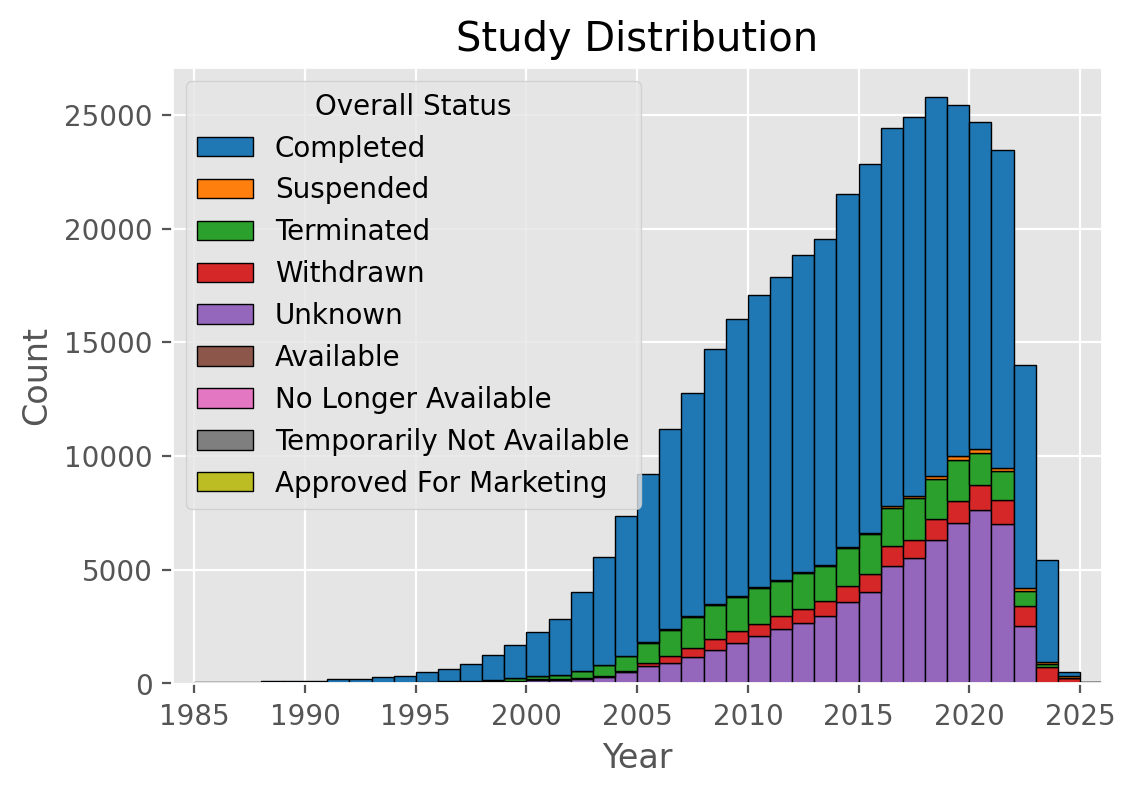

In [28]:
pretty_status = [status.replace('_', ' ').title() for status in recruitment + expanded_access]

fig, ax = plt.subplots(figsize=(6,4))

sns.histplot(studies, x='StartDate', 
             ax=ax,
             bins=date2num(pd.date_range(start='1984',end='2026',freq='YS')),
             hue='OverallStatus', 
             hue_order=recruitment + expanded_access, 
             multiple='stack',
             alpha=1, color='steelblue', edgecolor='black', palette='tab10')

plt.xlim((pd.to_datetime('1984'), pd.to_datetime('2026')))
plt.legend(handles=ax.get_legend().legend_handles, 
           title='Overall Status',
           labels=pretty_status)

plt.title('Study Distribution')
plt.xlabel('Year')
plt.show();

In [29]:
studies.select_dtypes('datetime').head()

,StatusVerifiedDate,StartDate,PrimaryCompletionDate,CompletionDate,StudyFirstSubmitDate,StudyFirstSubmitQCDate,LastUpdateSubmitDate,DispFirstSubmitDate,DispFirstSubmitQCDate
NCTId,,,,,,,,,
NCT01871896,2023-07-01,2014-01-01,2022-06-01,2022-06-01,2013-05-11,2013-06-04,2023-07-25,NaT,NaT
NCT00330096,2013-10-01,2006-03-01,NaT,2009-04-01,2006-05-24,2006-05-24,2015-10-28,NaT,NaT
NCT02247596,2014-09-01,2009-07-01,2012-10-01,2012-10-01,2014-09-17,2014-09-19,2014-09-19,NaT,NaT
NCT03110796,2019-01-01,2017-07-31,2020-01-01,2020-01-01,2017-03-30,2017-04-11,2019-01-16,NaT,NaT
NCT00405496,2006-11-01,2000-03-01,NaT,2001-04-01,2006-11-29,2006-11-29,2006-11-29,NaT,NaT


In [30]:
date_cols = list(studies.select_dtypes('datetime').columns)
print(date_cols)

indexed_date_cols = [col for col in date_cols if col != 'StartDate']
print(indexed_date_cols)

['StatusVerifiedDate', 'StartDate', 'PrimaryCompletionDate', 'CompletionDate', 'StudyFirstSubmitDate', 'StudyFirstSubmitQCDate', 'LastUpdateSubmitDate', 'DispFirstSubmitDate', 'DispFirstSubmitQCDate']
['StatusVerifiedDate', 'PrimaryCompletionDate', 'CompletionDate', 'StudyFirstSubmitDate', 'StudyFirstSubmitQCDate', 'LastUpdateSubmitDate', 'DispFirstSubmitDate', 'DispFirstSubmitQCDate']


In [31]:
studies.loc[studies['StartDate'].isna(), 'StartDate'] = studies.loc[studies['StartDate'].isna(), date_cols].min(axis=1)
studies['StartDate'].isna().sum()

0

StandarScaler won't work with the pd.Timedelta data type, so they must be converted to float as well.

In [32]:
for col in indexed_date_cols:
    studies[col] = (studies[col] - studies['StartDate']).dt.total_seconds().astype(np.float32)

#### Encode `StartDate` Year as Category
While not giving a full timeseries analysis of trends in clinical trial success rates, the year will be taken into account in order to provide categorical predictive information.

In [33]:
studies['StartDate'] = studies['StartDate'].dt.year.astype('category')
ohe_cols.append('StartDate')
studies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383135 entries, NCT01871896 to NCT05083533
Data columns (total 69 columns):
 #   Column                                          Non-Null Count   Dtype   
---  ------                                          --------------   -----   
 0   OrgClass                                        383135 non-null  category
 1   StatusVerifiedDate                              383135 non-null  float32 
 2   OverallStatus                                   383135 non-null  category
 3   HasExpandedAccess                               378669 non-null  category
 4   StartDate                                       383135 non-null  category
 5   PrimaryCompletionDate                           362437 non-null  float32 
 6   PrimaryCompletionDateType                       362374 non-null  category
 7   CompletionDate                                  367623 non-null  float32 
 8   CompletionDateType                              360842 non-null  category
 9   Study

### Handle NaNs
For all categorical variables undergoing OneHotEncoding, NaN values will be filled with the string 'No_data'. This is done under the assumption that there is information in the fact of whether data were recorded for not, which may have predictive value.

NaN values in the columns undergoing MultiHotEncoding will happen as part of that process via a custom-built function.

In [34]:
studies[ohe_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 383135 entries, NCT01871896 to NCT05083533
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   LargeDocNoSAP                      492 non-null     category
 1   BioSpecRetention                   16088 non-null   category
 2   DesignAllocation                   292248 non-null  category
 3   DesignInterventionModel            291361 non-null  category
 4   DesignMasking                      292702 non-null  category
 5   DesignObservationalModel           78431 non-null   category
 6   DesignPrimaryPurpose               290850 non-null  category
 7   DesignTimePerspective              81329 non-null   category
 8   EnrollmentType                     367054 non-null  category
 9   ExpAccTypeIndividual               254 non-null     category
 10  ExpAccTypeIntermediate             177 non-null     category
 11  ExpAccTypeTreatm

In [35]:
studies[studies.select_dtypes('category').columns] = studies.select_dtypes('category').apply(lambda x: x.cat.add_categories(nan_str))
studies[ohe_cols] = studies[ohe_cols].fillna(nan_str)
studies[ohe_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 383135 entries, NCT01871896 to NCT05083533
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   LargeDocNoSAP                      383135 non-null  category
 1   BioSpecRetention                   383135 non-null  category
 2   DesignAllocation                   383135 non-null  category
 3   DesignInterventionModel            383135 non-null  category
 4   DesignMasking                      383135 non-null  category
 5   DesignObservationalModel           383135 non-null  category
 6   DesignPrimaryPurpose               383135 non-null  category
 7   DesignTimePerspective              383135 non-null  category
 8   EnrollmentType                     383135 non-null  category
 9   ExpAccTypeIndividual               383135 non-null  category
 10  ExpAccTypeIntermediate             383135 non-null  category
 11  ExpAccTypeTreatm

In [36]:
studies.select_dtypes(exclude=['category', 'object']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 383135 entries, NCT01871896 to NCT05083533
Data columns (total 13 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   StatusVerifiedDate                              383135 non-null  float32
 1   PrimaryCompletionDate                           362437 non-null  float32
 2   CompletionDate                                  367623 non-null  float32
 3   StudyFirstSubmitDate                            383135 non-null  float32
 4   StudyFirstSubmitQCDate                          383135 non-null  float32
 5   LastUpdateSubmitDate                            383135 non-null  float32
 6   EnrollmentCount                                 377102 non-null  float32
 7   MinimumAge                                      356813 non-null  float32
 8   MaximumAge                                      206927 non-null  float32
 9   DispFirstSubmitD

### Encode Categorical Independent Variables

Total fields selected for encoding and analysis (inclusive of target field):

In [37]:
studies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383135 entries, NCT01871896 to NCT05083533
Data columns (total 69 columns):
 #   Column                                          Non-Null Count   Dtype   
---  ------                                          --------------   -----   
 0   OrgClass                                        383135 non-null  category
 1   StatusVerifiedDate                              383135 non-null  float32 
 2   OverallStatus                                   383135 non-null  category
 3   HasExpandedAccess                               383135 non-null  category
 4   StartDate                                       383135 non-null  category
 5   PrimaryCompletionDate                           362437 non-null  float32 
 6   PrimaryCompletionDateType                       383135 non-null  category
 7   CompletionDate                                  367623 non-null  float32 
 8   CompletionDateType                              383135 non-null  category
 9   Study

#### Encode Single-Value Fields

In [38]:
studies[ohe_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 383135 entries, NCT01871896 to NCT05083533
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   LargeDocNoSAP                      383135 non-null  category
 1   BioSpecRetention                   383135 non-null  category
 2   DesignAllocation                   383135 non-null  category
 3   DesignInterventionModel            383135 non-null  category
 4   DesignMasking                      383135 non-null  category
 5   DesignObservationalModel           383135 non-null  category
 6   DesignPrimaryPurpose               383135 non-null  category
 7   DesignTimePerspective              383135 non-null  category
 8   EnrollmentType                     383135 non-null  category
 9   ExpAccTypeIndividual               383135 non-null  category
 10  ExpAccTypeIntermediate             383135 non-null  category
 11  ExpAccTypeTreatm

In [39]:
ohe = OneHotEncoder(sparse_output=False, 
                    max_categories=ohe_max_categories,
                    dtype=bool)

studies = studies.drop(columns=ohe_cols).merge(pd.DataFrame(ohe.fit_transform(studies[ohe_cols].astype(str)), 
                                                            index=studies.index, 
                                                            columns=ohe.get_feature_names_out()),
                                               left_index=True,
                                               right_index=True)

In [40]:
studies.dtypes.value_counts()

bool        240
object       18
float32      12
category      1
Name: count, dtype: int64

#### Unpack and Encode List Values

The data contain several columns containing lists of data values, which can include more than value per study. Alongside typical OneHotEncoding of categorical independent variables, these will need to be encoded such that more than one column may contain a binary indicator. Initially these will be encoded as value counts, but may be reduced later to binary indicators depending on whether counts are descriptive of the variable in question.

In [41]:
for col in mhe_cols:
    studies = studies.drop(columns=col).merge(unpack_list(studies[col]), 
                                              left_index = True, 
                                              right_index=True)

In [42]:
for col in mhe_str_cols_count_only:
    studies = studies.drop(columns=col).merge(unpack_list(studies[col], max_categories=2, make_lowercase=True).drop(columns='num_' + col), 
                                              left_index = True, 
                                              right_index=True)

In [43]:
for col in mhe_str_cols_max_50:
    studies = studies.drop(columns=col).merge(unpack_list(studies[col], max_categories=50, make_lowercase=True), 
                                              left_index = True, 
                                              right_index=True)

In [44]:
for col in mhe_str_cols_max_100:
    studies = studies.drop(columns=col).merge(unpack_list(studies[col], max_categories=100, make_lowercase=True), 
                                              left_index = True, 
                                              right_index=True)

/var/folders/s6/0vh_sq0x1rdd9mlrgt5hxy9m0000gn/T/ipykernel_26638/2612367729.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.int32()


### Save Encoded Data to File

In [45]:
# Pickle the encoded DataFrame
studies.to_pickle(data_path + 'studies_encoded.pkl.bz2', compression='bz2')